<a href="https://colab.research.google.com/github/luizahelenalucena/Trabalho-CEP---Luiza-Helena/blob/main/Trabalho_CEP_Luiza_Helena_vf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8')

In [2]:
url = "https://raw.githubusercontent.com/luizahelenalucena/Trabalho-CEP---Luiza-Helena/refs/heads/main/preprocessed_trendedpointalarm%202.csv"
df = pd.read_csv(url)
df = pd.read_csv(url, sep=';')

In [3]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102319 entries, 0 to 102318
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   DateTime            102319 non-null  object
 1   ProcessID           102319 non-null  object
 2   AssetID             102048 non-null  object
 3   AlarmSeverityName   102319 non-null  object
 4   State               102319 non-null  object
 5   TransactionMessage  101725 non-null  object
 6   Stage               99335 non-null   object
 7   AlarmClassName      102319 non-null  object
 8   Year                102319 non-null  int64 
 9   Month               102319 non-null  int64 
 10  Day                 102319 non-null  int64 
 11  DayOfWeek           102319 non-null  object
 12  Season              102319 non-null  object
 13  Hour                102319 non-null  int64 
 14  ProcessedMessage    101725 non-null  object
dtypes: int64(4), object(11)
memory usage: 11.7+ MB


,DateTime,ProcessID,AssetID,AlarmSeverityName,State,TransactionMessage,Stage,AlarmClassName,Year,Month,Day,DayOfWeek,Season,Hour,ProcessedMessage
0,02/01/2018 22:45,IBMS/201801024100783,1-JK1-JK1-01-E.02-AC-ACON-VAVU-0047,3 - Low,A2N,VAV-J09-01-029 SPACE TEMP ALARM,Cancelled,General-ELV,2018,1,2,Tuesday,Winter,22,vavj0901029 space temp alarm
1,03/01/2018 01:41,IBMS/201801024101029,1-JK1-JK1-00-C.27-AC-ACON-VAVU-0019,3 - Low,A2N,VAV-J09-00-027 SPACE TEMP ALARM,Cancelled,General-ELV,2018,1,3,Wednesday,Winter,1,vavj0900027 space temp alarm
2,03/01/2018 03:08,IBMS/201801034101175,1-JK1-JK1-00-C.27-AC-ACON-VAVU-0019,3 - Low,A2N,VAV-J09-00-027 SPACE TEMP ALARM,Cancelled,General-ELV,2018,1,3,Wednesday,Winter,3,vavj0900027 space temp alarm
3,03/01/2018 07:12,IBMS/201801034101667,1-JK1-JK1-00-D.01-AC-ACON-VAVU-0021,3 - Low,A2N,VAV-J09-00-029 SPACE TEMP ALARM,Cancelled,General-ELV,2018,1,3,Wednesday,Winter,7,vavj0900029 space temp alarm
4,03/01/2018 09:04,IBMS/201801034102043,0-JK1-JK1-B2-1.01-AC-ACON-MAHU-0003,2 - Medium,A2N,MAU-JK1-B1-001 Dis Air Temp,Cancelled,General-ELV,2018,1,3,Wednesday,Winter,9,maujk1b1001 dis air temp


In [4]:
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
print(f"Total de colunas numéricas: {len(num_cols)}")
print(num_cols[:10])

Total de colunas numéricas: 4
Index(['Year', 'Month', 'Day', 'Hour'], dtype='object')


In [5]:
df['DateTime'] = pd.to_datetime(df['DateTime'], errors='coerce')
df = df.dropna(subset=['DateTime'])
df = df.sort_values('DateTime')

In [6]:
mapa_severidade = {
    '1 - Critical': 4,
    '2 - Medium': 3,
    '3 - Low': 2,
    '4 - Info': 1
}

df['SeverityLevel'] = df['AlarmSeverityName'].map(mapa_severidade)
df = df.dropna(subset=['SeverityLevel'])

In [7]:
df_hourly = df.groupby('Hour')['SeverityLevel'].mean().reset_index()
df_hourly.head()

,Hour,SeverityLevel
0,0,2.432177
1,1,2.242775
2,2,2.277567
3,3,2.783181
4,4,2.257143


In [8]:
# Parâmetros
xbar = df_hourly['SeverityLevel'].mean()
sigma = df_hourly['SeverityLevel'].std()

# Limites de controle (3 sigmas)
UCL = xbar + 3 * sigma
LCL = xbar - 3 * sigma

print(f"Média: {xbar:.2f}, UCL: {UCL:.2f}, LCL: {LCL:.2f}")

Média: 2.40, UCL: 2.79, LCL: 2.01


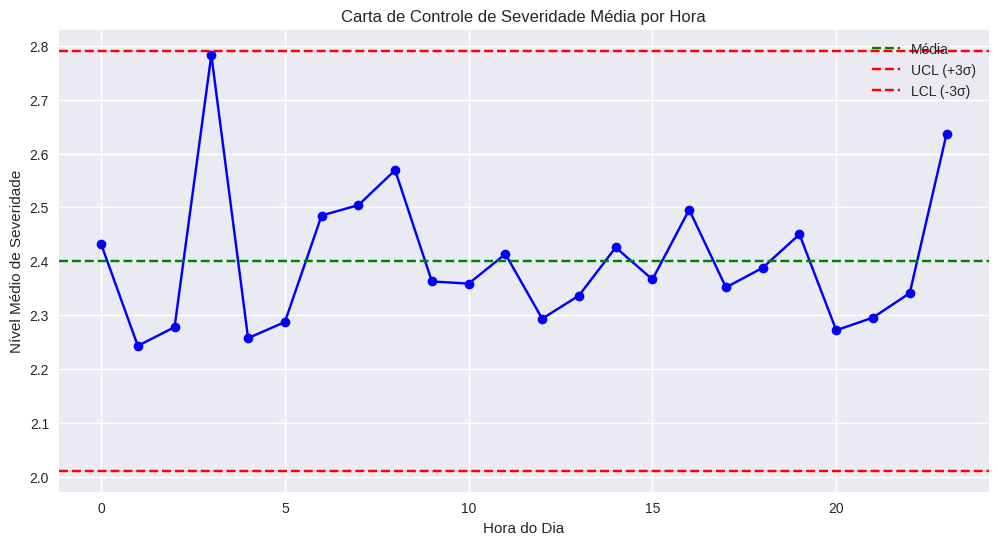

In [9]:
plt.figure(figsize=(12,6))
plt.plot(df_hourly['Hour'], df_hourly['SeverityLevel'], marker='o', linestyle='-', color='blue')
plt.axhline(xbar, color='green', linestyle='--', label='Média')
plt.axhline(UCL, color='red', linestyle='--', label='UCL (+3σ)')
plt.axhline(LCL, color='red', linestyle='--', label='LCL (-3σ)')

plt.title('Carta de Controle de Severidade Média por Hora')
plt.xlabel('Hora do Dia')
plt.ylabel('Nível Médio de Severidade')
plt.legend()
plt.grid(True)
plt.show()

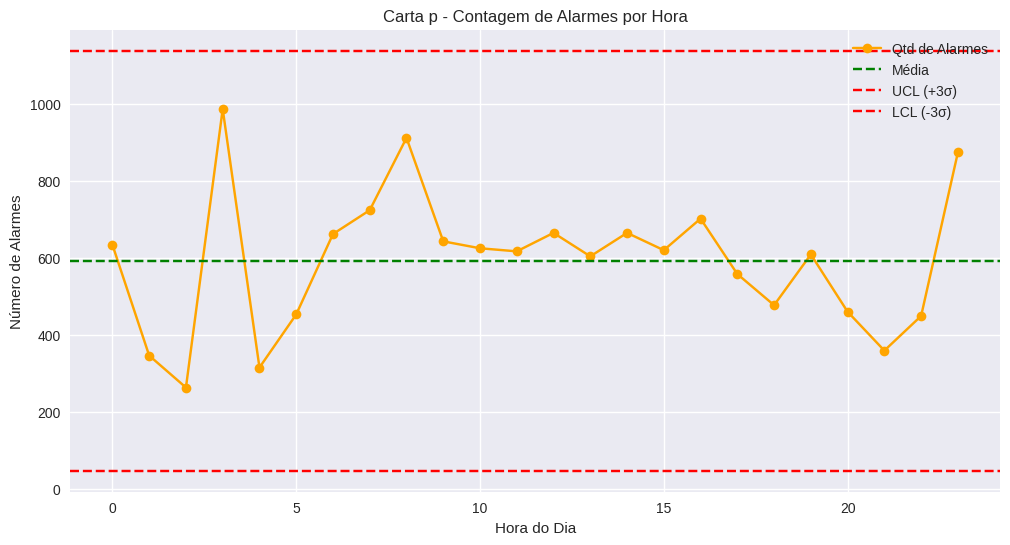

In [10]:
df_hourly = df.groupby('Hour').agg({
    'SeverityLevel': 'mean',
    'AlarmSeverityName': 'count'
}).rename(columns={'AlarmSeverityName': 'AlarmCount'}).reset_index()

pbar = df_hourly['AlarmCount'].mean()
std_p = df_hourly['AlarmCount'].std()
UCLp = pbar + 3 * std_p
LCLp = max(pbar - 3 * std_p, 0)

plt.figure(figsize=(12,6))
plt.plot(df_hourly['Hour'], df_hourly['AlarmCount'], marker='o', color='orange', label='Qtd de Alarmes')
plt.axhline(pbar, color='green', linestyle='--', label='Média')
plt.axhline(UCLp, color='red', linestyle='--', label='UCL (+3σ)')
plt.axhline(LCLp, color='red', linestyle='--', label='LCL (-3σ)')
plt.title('Carta p - Contagem de Alarmes por Hora')
plt.xlabel('Hora do Dia')
plt.ylabel('Número de Alarmes')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
f_hourly = df.groupby('Hour').agg({
    'SeverityLevel': 'mean',
    'AlarmSeverityName': 'count'
}).rename(columns={'AlarmSeverityName': 'AlarmCount'}).reset_index()

In [12]:
xbar = df_hourly['SeverityLevel'].mean()
sigma = df_hourly['SeverityLevel'].std()
UCL = xbar + 3 * sigma
LCL = xbar - 3 * sigma

In [13]:
outliers = df_hourly[(df_hourly['SeverityLevel'] > UCL) | (df_hourly['SeverityLevel'] < LCL)]
print("⚠️ Pontos fora de controle encontrados:")
print(outliers)

⚠️ Pontos fora de controle encontrados:
Empty DataFrame
Columns: [Hour, SeverityLevel, AlarmCount]
Index: []


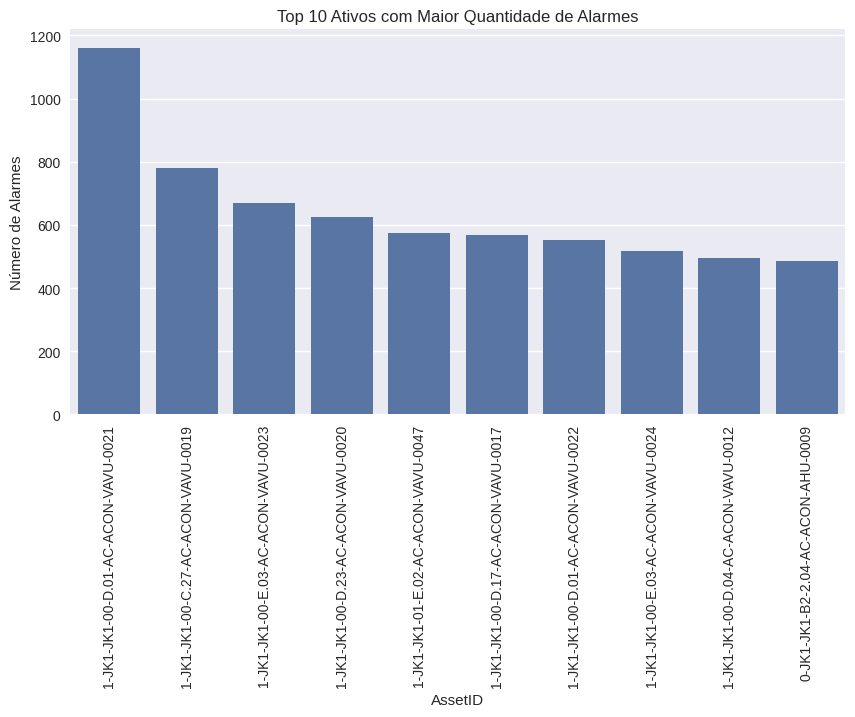

In [14]:
df_asset = df.groupby('AssetID').agg({
    'SeverityLevel': 'mean',
    'AlarmSeverityName': 'count'
}).rename(columns={'AlarmSeverityName': 'AlarmCount'}).reset_index()

top_assets = df_asset.sort_values('AlarmCount', ascending=False).head(10)

plt.figure(figsize=(10,5))
sns.barplot(x='AssetID', y='AlarmCount', data=top_assets)
plt.xticks(rotation=90)
plt.title('Top 10 Ativos com Maior Quantidade de Alarmes')
plt.xlabel('AssetID')
plt.ylabel('Número de Alarmes')
plt.show()